# Solving CartPole-v0 with the policy gradient algorithm REINFOCE

load env and packages

In [100]:
import numpy as np
import gym
import torch
from matplotlib import pyplot as plt
from tqdm.notebook import trange, tqdm

In [101]:
env = gym.make('CartPole-v0')

try out the env

In [102]:
initial_state = env.reset()
action = env.action_space.sample()
state, reward, done, info = env.step(action)

In [103]:
def print_step(state, reward, done, info):
    print(f"state: {state},\nreward: {reward},\ndone: {done},\ninfo: {info}")

In [104]:
def running_mean(x, N=50):
    kernel = np.ones(N)
    conv_len = x.shape[0]-N
    y = np.zeros(conv_len)
    for i in range(conv_len):
        y[i] = kernel @ x[i:i+N]
        y[i] /= N
    return y

Create the policy network

In [105]:
l1 = 4
l2 = 150
l3 = 2

model = torch.nn.Sequential(
    torch.nn.Linear(l1, l2),
    torch.nn.LeakyReLU(),
    torch.nn.Linear(l2, l3),
    torch.nn.Softmax(dim=0)
)

learning_rate = 0.009
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [106]:
initial_state = env.reset()
pred = model(torch.from_numpy(initial_state).float())
action = np.random.choice(np.array([0,1]), p=pred.data.numpy())
state, reward, done, info = env.step(action)
print_step(state, reward, done, info)

state: [-0.01679294 -0.1881184  -0.00906211  0.28138468],
reward: 1.0,
done: False,
info: {}


In [107]:
def discount_rewards(rewards, gamma=.99):
    lenr = len(rewards)
    discounted_return = torch.pow(gamma, torch.arange(lenr).float()) * rewards
    discounted_return /= discounted_return.max()
    return discounted_return

In [108]:
def loss_fn(preds, rewards):
    return -1 * torch.sum(rewards * torch.log(preds))

Training the REINFORCE ALGORITHM

In [113]:
MAX_DUR = 200
MAX_EPISODES = 500
gamma = 0.99

action_space = np.array([0,1])
score = []

for episode in tqdm(range(MAX_EPISODES)):
    state = env.reset()
    done = False
    experiences = []
    
    for t in range(MAX_DUR):
        action_prob = model(torch.from_numpy(state).float())
        action = np.random.choice(action_space, p=action_prob.data.numpy())
        prev_state = state
        state, _, done, info = env.step(action)
        experiences.append((prev_state, action, t+1))
        
        if done:
            break
            
    ep_len = len(experiences)
    score.append(ep_len)
    reward_batch = torch.Tensor([r for (s,a,r) in experiences]).flip(dims=(0,))
    discounted_reward = discount_rewards(reward_batch)

    state_batch = torch.Tensor([s for (s,a,r) in experiences])
    action_batch = torch.Tensor([a for (s,a,r) in experiences])
    pred_batch = model(state_batch)
    prob_batch = pred_batch.gather(dim=1, index=action_batch.long().view(-1,1)).squeeze()

    loss = loss_fn(prob_batch, discounted_reward)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
        

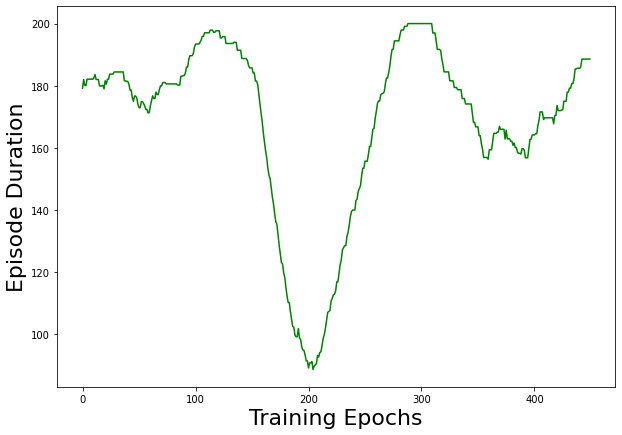

In [114]:
score = np.array(score)
avg_score = running_mean(score, 50)

plt.figure(figsize=(10,7))
plt.ylabel("Episode Duration",fontsize=22)
plt.xlabel("Training Epochs",fontsize=22)
plt.plot(avg_score, color='green')

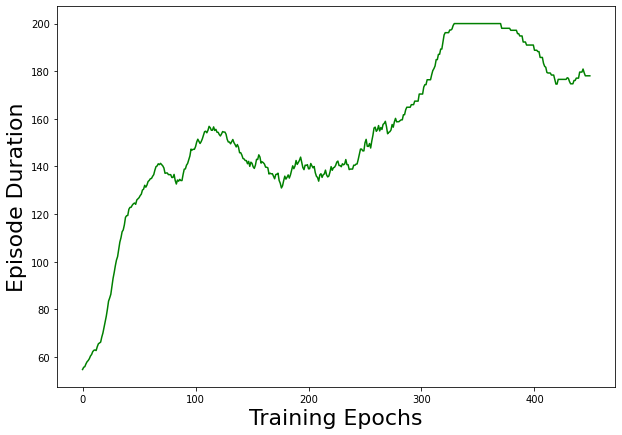

In [112]:
score1 = np.array(score)
avg_score1 = running_mean(score1, 50)

plt.figure(figsize=(10,7))
plt.ylabel("Episode Duration",fontsize=22)
plt.xlabel("Training Epochs",fontsize=22)
plt.plot(avg_score1, color='green')